### Stock Trading Strategy using Classification Algorithms to Predict Market Movements and Backtesting

In [29]:

%load_ext autoreload
%autoreload 2
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import pyfolio as pf # install with pip install git+ssh://git@github.com/giocaizzi/pyfolio.git
import warnings

from surfingcrypto import Config,TS
from surfingcrypto.algotrading.objects import BackTest

# set the style and ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Gathering

In [30]:
c = Config("/Users/giorgiocaizzi/Documents/GitHub/surfingcrypto/config")
ticker = "ETH"
ts = TS(c, coin=ticker)
ts.ta_indicators()
ts.df


,Open,High,Low,Close,Volume,Market Cap,SMA_26,SMA_12,SMA_200,SMA_100,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14
Date,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00+00:00,255.288687,256.747390,249.797667,256.044212,2.593030e+08,2.430109e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-02 00:00:00+00:00,256.167001,256.711876,250.857533,253.580263,2.893556e+08,2.407106e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-03 00:00:00+00:00,253.587078,256.395551,245.386642,248.989454,2.738634e+08,2.363906e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-04 00:00:00+00:00,249.237185,254.456920,247.380720,248.964687,2.194011e+08,2.364053e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-05 00:00:00+00:00,249.062535,254.518348,245.716713,252.593705,2.166371e+08,2.398902e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-27 00:00:00+00:00,2638.961735,2760.264746,2633.873724,2737.246508,1.650468e+10,3.299868e+11,2872.641744,2772.283073,3078.698523,2624.161686,-35.027221,-19.064872,-15.962349,2636.436971,2807.861370,2979.285768,12.210318,0.294035,46.401486
2022-04-28 00:00:00+00:00,2737.170731,2829.927949,2722.236122,2796.114694,1.755916e+10,3.371209e+11,2860.218772,2769.263272,3077.868604,2624.194868,-30.104679,-11.313864,-18.790815,2639.689345,2800.925386,2962.161427,11.513055,0.485082,49.689603
2022-04-29 00:00:00+00:00,2795.958104,2799.331664,2638.366447,2670.412570,1.780309e+10,3.220012e+11,2840.263514,2761.113524,3075.877261,2623.606874,-35.932433,-13.713294,-22.219138,2641.408870,2784.493608,2927.578345,10.277254,0.101351,43.546417


### Feature Engineering

The chosen algo uses binary encoding for upward or downward movements.

#### Signals

- SMA Cross
- MACD
- Bollinger Bands
- RSI

In [31]:
def sma_signal(serie: pd.Series,colnames=["SMA_12","SMA_26"]):
    if not pd.isna(serie[colnames[0]]) and not pd.isna(serie[colnames[1]]):
        if serie[colnames[0]] < serie[colnames[1]]:
            return 0
        else:
            return 1
    else:
        np.nan


def macd_signal(serie: pd.Series):
    if not pd.isna(serie["MACDh_12_26_9"]):
        if serie["MACDh_12_26_9"] > 0:
            return 1
        else:
            return 0
    else:
        return np.nan


# IF PREV_STOCK > PREV_LOWERBB & CUR_STOCK < CUR_LOWER_BB => BUY
# IF PREV_STOCK < PREV_UPPERBB & CUR_STOCK > CUR_UPPER_BB => SELL
def bb_signal(serie: pd.Series, buffer=0.1):
    if (
        not pd.isna(serie["PREV_STOCK"])
        and not pd.isna(serie["PREV_LOWERBB"])
        and not pd.isna(serie["PREV_UPPERBB"])
    ):
        if (
            serie["PREV_STOCK"]
            > serie["PREV_LOWERBB"] + serie["PREV_LOWERBB"] * buffer
            and serie["Close"]
            < serie["BBL_20_2.0"] + serie["BBL_20_2.0"] * buffer
        ):
            return 1
        elif (
            serie["PREV_STOCK"]
            < serie["PREV_UPPERBB"] - serie["PREV_UPPERBB"] * buffer
            and serie["Close"]
            > serie["BBU_20_2.0"] - serie["BBU_20_2.0"] * buffer
        ):
            return 0
    else:
        return np.nan
# IF PREVIOUS RSI > 30 AND CURRENT RSI < 30 ==> BUY SIGNAL
# IF PREVIOUS RSI < 70 AND CURRENT RSI > 70 ==> SELL SIGNAL
def rsi_signal(serie:pd.Series,lower=30,upper=70):
    if not pd.isna(serie["PREV_RSI"]):
        if serie["PREV_RSI"]>lower and serie["RSI_14"]<lower:
            return 1
        elif serie["PREV_RSI"]<upper and serie["RSI_14"]>upper:
            return 0
    else:
        return np.nan



In [32]:
signals = ts.df

#SMA
signals["SMA_12_26_Signal"] = signals.apply(sma_signal, axis=1)
signals["SMA_100_200_Signal"] = signals.apply(sma_signal,args=(["SMA_100","SMA_200"],), axis=1)

#MACD
signals["MACD_12_26_9_Signal"] = signals.apply(macd_signal, axis=1)

## BB
signals["PREV_STOCK"] = signals["Close"].shift(1)
signals["PREV_LOWERBB"] = signals["BBL_20_2.0"].shift(1)
signals["PREV_UPPERBB"] = signals["BBU_20_2.0"].shift(1)
signals["BBL_20_2_Signal"] = signals.apply(bb_signal, args=(0),axis=1)
signals["BBL_20_2_Signal"]=signals["BBL_20_2_Signal"].fillna(method="bfill")
signals["BBL_20_2_Signal"]=signals["BBL_20_2_Signal"].fillna(method="ffill")

# RSI
signals["PREV_RSI"] = signals["RSI_14"].shift(1)
signals["RSI_14_Signal"]=signals.apply(rsi_signal,axis=1)
signals["RSI_14_Signal"]=signals["RSI_14_Signal"].fillna(method="bfill")
signals["RSI_14_Signal"]=signals["RSI_14_Signal"].fillna(method="ffill")


signals


,Open,High,Low,Close,Volume,Market Cap,SMA_26,SMA_12,SMA_200,SMA_100,...,RSI_14,SMA_12_26_Signal,SMA_100_200_Signal,MACD_12_26_9_Signal,PREV_STOCK,PREV_LOWERBB,PREV_UPPERBB,BBL_20_2_Signal,PREV_RSI,RSI_14_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00+00:00,255.288687,256.747390,249.797667,256.044212,2.593030e+08,2.430109e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0
2017-10-02 00:00:00+00:00,256.167001,256.711876,250.857533,253.580263,2.893556e+08,2.407106e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,256.044212,NaN,NaN,0.0,NaN,0.0
2017-10-03 00:00:00+00:00,253.587078,256.395551,245.386642,248.989454,2.738634e+08,2.363906e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,253.580263,NaN,NaN,0.0,NaN,0.0
2017-10-04 00:00:00+00:00,249.237185,254.456920,247.380720,248.964687,2.194011e+08,2.364053e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,248.989454,NaN,NaN,0.0,NaN,0.0
2017-10-05 00:00:00+00:00,249.062535,254.518348,245.716713,252.593705,2.166371e+08,2.398902e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,248.964687,NaN,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-27 00:00:00+00:00,2638.961735,2760.264746,2633.873724,2737.246508,1.650468e+10,3.299868e+11,2872.641744,2772.283073,3078.698523,2624.161686,...,46.401486,0.0,0.0,0.0,2638.634988,2636.853389,3002.735627,0.0,40.336020,0.0
2022-04-28 00:00:00+00:00,2737.170731,2829.927949,2722.236122,2796.114694,1.755916e+10,3.371209e+11,2860.218772,2769.263272,3077.868604,2624.194868,...,49.689603,0.0,0.0,0.0,2737.246508,2636.436971,2979.285768,0.0,46.401486,0.0
2022-04-29 00:00:00+00:00,2795.958104,2799.331664,2638.366447,2670.412570,1.780309e+10,3.220012e+11,2840.263514,2761.113524,3075.877261,2623.606874,...,43.546417,0.0,0.0,0.0,2796.114694,2639.689345,2962.161427,0.0,49.689603,0.0


In [33]:
signals["RSI_14_Signal"].isna().value_counts()

False    1674
Name: RSI_14_Signal, dtype: int64

In [54]:

dicts = {}
indicatori = [
    "SMA_12_26_Signal",
    "SMA_100_200_Signal",
    "MACD_12_26_9_Signal",
    "BBL_20_2_Signal",
    "RSI_14_Signal"
    ]
for i in range(len(indicatori)):
        dicts["i_"+"{}".format(str(i+1).zfill(2))] = indicatori[i]
indicatori=dicts


indicatori

{'i_01': 'SMA_12_26_Signal',
 'i_02': 'SMA_100_200_Signal',
 'i_03': 'MACD_12_26_9_Signal',
 'i_04': 'BBL_20_2_Signal',
 'i_05': 'RSI_14_Signal'}

In [35]:
stock = signals[["Close"] + list(indicatori.values())]
stock.rename(columns={"Close": ticker}, inplace=True)
stock.rename(
    columns={v: k for k, v in indicatori.items()}, inplace=True
)  # reversed dict
# calculate daily log returns and market direction
stock["returns"] = np.log(stock[ticker] / stock[ticker].shift(1))
stock.dropna(inplace=True)
stock["direction"] = np.sign(stock["returns"]).astype(int)
stock.tail(2)


,ETH,i_00,i_01,i_02,i_03,i_04,returns,direction
Date,,,,,,,,
2022-04-30 00:00:00+00:00,2589.402008,0.0,0.0,0.0,0.0,0.0,-0.030806,-1
2022-05-01 00:00:00+00:00,2684.165515,0.0,0.0,0.0,0.0,0.0,0.035943,1


In [36]:


# define the number of lags
lags = [1,2,3,7,14]

# compute lagged log returns
cols = []
for key in indicatori:
    for lag in lags:
        col = f"{key}_lag{str(lag).zfill(2)}"
        stock[col] = stock[key].shift(lag)
        cols.append(col)

stock.dropna(inplace=True)
import re
# set columns
cols_bin = []
for col in stock.columns:
    if col[:2]=="i_":
        if re.match(r"(i_[0-9]{2})_(lag[0-9]{2})", col):
            cols_bin.append(col)

stock.tail(2)


,ETH,i_00,i_01,i_02,i_03,i_04,returns,direction,i_00_lag01,i_00_lag02,...,i_03_lag01,i_03_lag02,i_03_lag03,i_03_lag07,i_03_lag14,i_04_lag01,i_04_lag02,i_04_lag03,i_04_lag07,i_04_lag14
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-30 00:00:00+00:00,2589.402008,0.0,0.0,0.0,0.0,0.0,-0.030806,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-01 00:00:00+00:00,2684.165515,0.0,0.0,0.0,0.0,0.0,0.035943,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
cols_bin


['i_00_lag01',
 'i_00_lag02',
 'i_00_lag03',
 'i_00_lag07',
 'i_00_lag14',
 'i_01_lag01',
 'i_01_lag02',
 'i_01_lag03',
 'i_01_lag07',
 'i_01_lag14',
 'i_02_lag01',
 'i_02_lag02',
 'i_02_lag03',
 'i_02_lag07',
 'i_02_lag14',
 'i_03_lag01',
 'i_03_lag02',
 'i_03_lag03',
 'i_03_lag07',
 'i_03_lag14',
 'i_04_lag01',
 'i_04_lag02',
 'i_04_lag03',
 'i_04_lag07',
 'i_04_lag14']

### Build and Apply Classification Machine Learning Algorithms

Select Logistic regression, Gaussian Naive Bayes, Support Vector Machine, Random Forest, and MLP Classifier approaches to predict the market direction. Please refer sklearn documentation for detail on these and other algorithms.
https://scikit-learn.org/stable/index.html

In [38]:
# create a dictionary of selected algorithms
models = {
    "log_reg": linear_model.LogisticRegression(),
    "gauss_nb": GaussianNB(),
    "svm": SVC(),
    "random_forest": RandomForestClassifier(max_depth=10, n_estimators=100),
    "MLP": MLPClassifier(max_iter=500),
}


In [39]:
# function that fits all models.
def fit_models(data):
    mfit = {
        model: models[model].fit(data[cols_bin], data["direction"])
        for model in models.keys()
    }



In [40]:
# function that predicts (derives all position values) from the fitted models
def estimate_positions(data):
    for model in models.keys():
        data["pos_" + model] = models[model].predict(data[cols_bin])



In [41]:
# function to evaluate all trading strategies
def evaluate_strats(data):
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = "strategy_" + model
        data[col] = data["pos_" + model] * data["returns"]
        strategy_rtn.append(col)
    strategy_rtn.insert(0, "returns")



In [42]:
# fit the models
fit_models(stock)
# estimate
estimate_positions(stock)


In [43]:
stock["pos_MLP"].value_counts()

 1    789
-1    672
Name: pos_MLP, dtype: int64

In [44]:
## BACKTESTING NUMERICALLY

# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)
# calculate total return and std. deviation of each strategy
print("\nTotal Returns:")
print(stock[strategy_rtn].sum().apply(np.exp))
print("\nAnnual Volatility:")
stock[strategy_rtn].std() * 252 ** 0.5



Total Returns:
returns                   4.777691e+00
strategy_log_reg          1.530432e+05
strategy_gauss_nb         3.810131e+04
strategy_svm              1.310556e+08
strategy_random_forest    8.424598e+11
strategy_MLP              4.307137e+10
dtype: float64

Annual Volatility:


returns                   0.788389
strategy_log_reg          0.777822
strategy_gauss_nb         0.780193
strategy_svm              0.761953
strategy_random_forest    0.729907
strategy_MLP              0.742302
dtype: float64

In [45]:
stock.tail()

,ETH,i_00,i_01,i_02,i_03,i_04,returns,direction,i_00_lag01,i_00_lag02,...,pos_log_reg,pos_gauss_nb,pos_svm,pos_random_forest,pos_MLP,strategy_log_reg,strategy_gauss_nb,strategy_svm,strategy_random_forest,strategy_MLP
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-27 00:00:00+00:00,2737.246508,0.0,0.0,0.0,0.0,0.0,0.036691,1,0.0,0.0,...,1,1,-1,-1,1,0.036691,0.036691,-0.036691,-0.036691,0.036691
2022-04-28 00:00:00+00:00,2796.114694,0.0,0.0,0.0,0.0,0.0,0.021278,1,0.0,0.0,...,1,1,-1,-1,1,0.021278,0.021278,-0.021278,-0.021278,0.021278
2022-04-29 00:00:00+00:00,2670.412570,0.0,0.0,0.0,0.0,0.0,-0.045998,-1,0.0,0.0,...,1,1,1,-1,-1,-0.045998,-0.045998,-0.045998,0.045998,0.045998
2022-04-30 00:00:00+00:00,2589.402008,0.0,0.0,0.0,0.0,0.0,-0.030806,-1,0.0,0.0,...,1,1,1,-1,-1,-0.030806,-0.030806,-0.030806,0.030806,0.030806
2022-05-01 00:00:00+00:00,2684.165515,0.0,0.0,0.0,0.0,0.0,0.035943,1,0.0,0.0,...,1,1,1,-1,-1,0.035943,0.035943,0.035943,-0.035943,-0.035943


### Strategy evalutation using Backtrader

Strategy: 
1.	Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is -1.
2.	All-in strategy—when creating a buy order, buy as many shares as possible.
3.	Short selling is not allowed

In [46]:
start = "2021-01-01"

performance = {}
backtests = {}
for key in models.keys():
    prices = ts.df[["Open", "High", "Low", "Close", "Volume"]]
    prices = prices.loc[start:]
    prices.rename(
        columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume",
        },
        inplace=True,
    )
    # add the predicted column to prices dataframe. right joining them so to start from backtesting startdate.
    # predictions = stock[["strategy_" + key]]
    predictions = stock[["pos_" + key]]

    # predictions.rename(columns={"strategy_" + key: "predicted"}, inplace=True)

    predictions.rename(columns={"pos_" + key: "predicted"}, inplace=True)
    prices = predictions.join(prices, how="right").dropna()

    # run
    i_backtest = BackTest(prices, ticker, verbose=False)
    i_backtest.run()
    backtests[key] = i_backtest
    performance[key] = i_backtest.performance_stats().append(pd.Series([i_backtest.end_value],index=["End Value"]))
performance = pd.DataFrame(performance)



In [47]:
performance


,log_reg,gauss_nb,svm,random_forest,MLP
Annual return,2.111731,1.893763,2.642102,1.290916,1.068517
Cumulative returns,7.928728,6.761832,11.095051,3.946561,3.062294
Annual volatility,0.708772,0.769125,0.647516,0.615988,0.568793
Sharpe ratio,1.953299,1.769236,2.320365,1.651885,1.559576
Calmar ratio,5.222729,3.393815,7.268049,3.073941,2.798029
Stability,0.821334,0.881498,0.783588,0.517024,0.566540
Max drawdown,-0.404335,-0.558004,-0.363523,-0.419955,-0.381882
Omega ratio,1.493680,1.404767,1.613627,1.435594,1.439164
Sortino ratio,3.253374,2.745752,3.933336,2.733807,2.626895
Skew,0.585868,0.034165,0.460781,0.523307,0.726888


## Choose best model from backtesting results

Choose the one with the greates cumulative returns.

In [48]:
print(performance.loc["Cumulative returns"].idxmax())
backtest = backtests[performance.loc["Cumulative returns"].idxmax()]



svm


In [49]:
backtest.end_value

15118.813426516086

In [50]:
backtest.print_log()


2021-01-02, Open: 600.888, Close: 638.266
2021-01-02,     BUY CREATED --- Size: 2.060, Price: 600.860, Cost: 1237.500
2021-01-02,     BUY EXECUTED --- Size: 2.060, Price: 600.888, Cost: 1237.559, Commission: 12.376
2021-02-20, Open: 1617.316, Close: 1584.003
2021-02-20,     SELL CREATED --- Size: -2.060, Price: 1617.532, Cost: -3331.387
2021-02-20,     SELL EXECUTED --- Size: -2.060, Price: 1617.316, Cost: -3330.942, Commission: 33.309
2021-02-20,          -> OPERATION RESULT --- Gross: 2093.383, Net: 2047.698
2021-02-22, Open: 1596.353, Close: 1464.957
2021-02-22,     BUY CREATED --- Size: 2.045, Price: 1596.389, Cost: 3264.721
2021-02-22,     BUY EXECUTED --- Size: 2.045, Price: 1596.353, Cost: 3264.648, Commission: 32.646
2021-02-23, Open: 1464.477, Close: 1292.240
2021-02-23,     SELL CREATED --- Size: -2.045, Price: 1464.957, Cost: -2995.933
2021-02-23,     SELL EXECUTED --- Size: -2.045, Price: 1464.477, Cost: -2994.952, Commission: 29.950
2021-02-23,          -> OPERATION RESULT

# Plotting

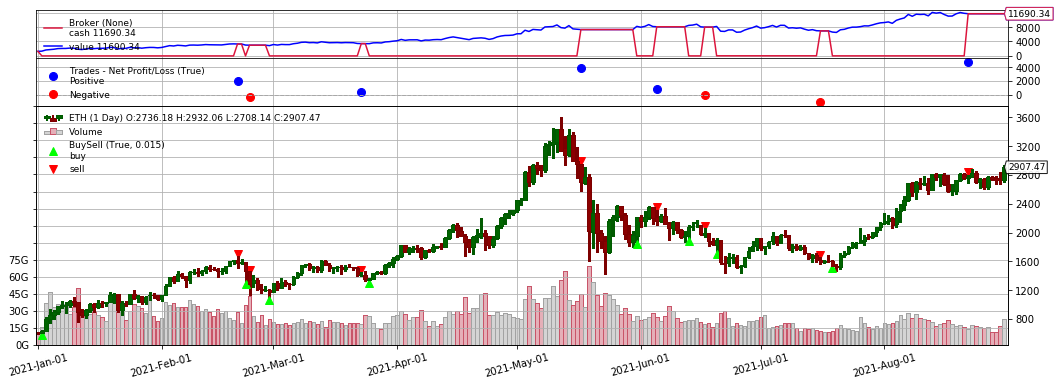

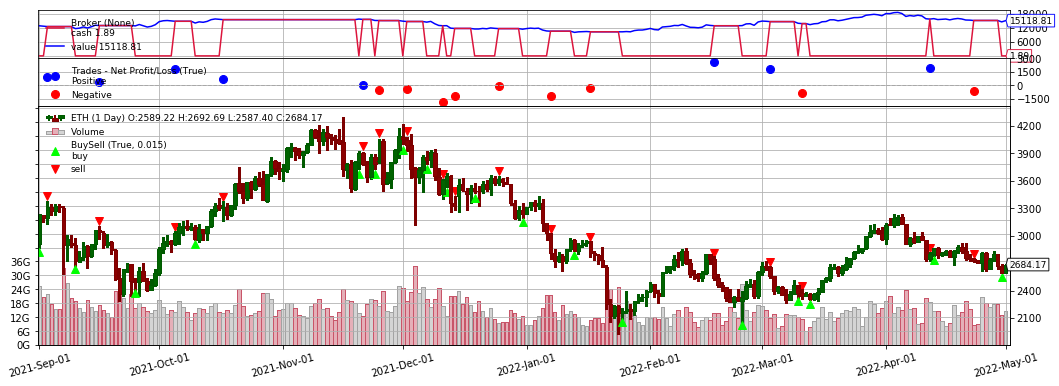

In [51]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 5]
figs = backtest.cerebro.plot(
    style="candlesticks",
    barup="darkgreen",
    bardown="darkred",
    numfigs=2,
    iplot=False,
    fmt_x_ticks="%Y-%b-%d",
)



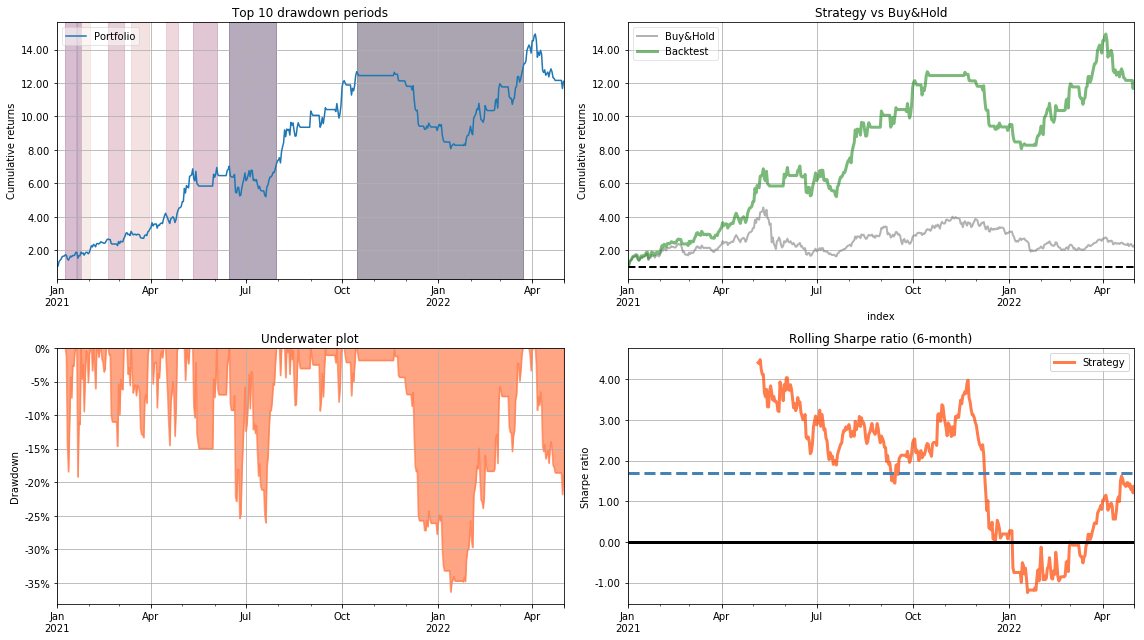

In [52]:
# plot performance for strategy vs benchmark

# get benchmark returns # just buy and hold
benchmark_rets = stock["returns"]
benchmark_rets = benchmark_rets.filter(backtest.returns.index)
benchmark_rets.name = "Buy&Hold"
benchmark_rets.tail()


fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(16, 9), constrained_layout=True
)
axes = ax.flatten()

pf.plot_drawdown_periods(returns=backtest.returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(
    returns=backtest.returns,
    factor_returns=benchmark_rets,
    ax=axes[1],
    title="Strategy vs Buy&Hold",
)
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=backtest.returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=backtest.returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('Strategy vs Nifty-50 (Buy and Hold)', fontsize=16, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('images/chart3', dpi=300)


# Apply to future

In [53]:
# apply to future

print(stock.iloc[-1].name)

future = stock.iloc[-1, 3:8].shift(1)
future.loc["rtn_lag1"] = 0.05
future = pd.DataFrame(future).T
create_bins(future)
future
future

models["svm"].predict(future[cols_bin].to_numpy().reshape(1, -1))


2022-05-01 00:00:00+00:00


NameError: name 'create_bins' is not defined